## Install Dependencies and Stable Baselines Using Pip

List of full dependencies can be found in the [README](https://github.com/hill-a/stable-baselines).

```
sudo apt-get update && sudo apt-get install cmake libopenmpi-dev zlib1g-dev
```


```
pip install stable-baselines[mpi]
```

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
! pip install keras==2.3.1

In [ ]:
# Stable Baselines only supports tensorflow 1.x for now
#!pip install tensorflow==1.13.2
#%tensorflow_version 1.x
!apt-get install ffmpeg freeglut3-dev xvfb  # For visualization
#!pip install stable-baselines[mpi]==2.10.0
!pip install stable-baselines3

Reading package lists... Done
Building dependency tree       
Reading state information... Done
freeglut3-dev is already the newest version (2.8.1-3).
ffmpeg is already the newest version (7:3.4.8-0ubuntu0.2).
xvfb is already the newest version (2:1.19.6-1ubuntu4.8).
0 upgraded, 0 newly installed, 0 to remove and 13 not upgraded.


## Imports

In [ ]:
import gym
import pickle
import torch as th
import torch.nn as nn
import os
import time

import stable_baselines3
#stable_baselines.__version__
from stable_baselines3 import DQN
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor
#from stable_baselines.common.env_util import make_vec_env
from stable_baselines3.common.callbacks import BaseCallback
#from stable_baselines.common.vec_env import unwrap_vec_normalize
#from stable_baselines.common.policies import ActorCriticCnnPolicy

## Limpando pastas locais

In [ ]:
#!rm -rf logs
#!rm -rf results
#!rm -rf videos

## Parâmetros e paths

In [ ]:
# AQUI
agent = 'DQN'
enviroment = 'MsPacman-v0'

timestr = time.strftime("%Y%m%d-%H%M%S")

experiment_name = agent + '_' + timestr

os.makedirs(experiment_name)

results_path = experiment_name + '/results_' + experiment_name
logdir = experiment_name + '/logs_' + experiment_name
videodir = experiment_name + '/videos_' + experiment_name

param_model = {
    'learning_rate': 0.0005,
    'buffer_size': 10000,
    'learning_starts': 50000,
    'batch_size': 32,
    'tau': 0.5,
    'gamma':0.99,
    'train_freq': 4,
    'gradient_steps': 1,
    'n_episodes_rollout': -1,
    'optimize_memory_usage': False,
    'target_update_interval':10000,
    'exploration_fraction':0.1,
    'exploration_initial_eps':1.0,
    'exploration_final_eps': 0.05,
    'max_grad_norm': 10,
    #'tensorboard_log': None,
    'create_eval_env': False,
    'verbose': 0,
    'seed': 1278,
    'device': 'auto', 
    '_init_setup_model': True 

}

param_learning = {
    'total_timesteps': 100000,
    'callback': None,
    'log_interval': 1,
    'reset_num_timesteps' : True
}

dim_features = 64
policy_name = 'CnnPolicy'

log = {**param_model, **param_learning}

log['policy_name'] = policy_name
log['dim_features'] = dim_features


## Implementação de callbacks

In [ ]:
import numpy as np

class EvalCallback(BaseCallback):
  """
  Callback for evaluating an agent.

  :param eval_env: (gym.Env) The environment used for initialization
  :param n_eval_episodes: (int) The number of episodes to test the agent
  :param eval_freq: (int) Evaluate the agent every eval_freq call of the callback.
  """
  def __init__(self, eval_env, deterministic=True, n_eval_episodes=5, eval_freq=200, path=results_path, verbose=1):
    super(EvalCallback, self).__init__(verbose)
    self.eval_env = eval_env
    self.deterministic = deterministic
    self.n_eval_episodes = n_eval_episodes
    self.eval_freq = eval_freq
    self.best_mean_reward = -np.inf
    self.save_path = os.path.join(path, 'best_model')

  def _on_step(self) -> bool:
    """
    This method will be called by the model.

    :return: (bool)
    """
    # self.n_calls is automatically updated because
    # we derive from BaseCallback
    if self.n_calls % self.eval_freq == 0:
      # Evaluate the agent:
      done = False
      all_episode_rewards = []
      lives = 0
      win = 0
      loss = 0
      obs = self.eval_env.reset()
      for _ in range(self.n_eval_episodes):
        episode_rewards = []
        while not done:
          action, _states = self.model.predict(obs, deterministic=self.deterministic)
          obs, reward, done, info = self.eval_env.step(action)
          lives = info[-1]['ale.lives']
          episode_rewards.append(reward)
        if (lives > 0):
          win += 1
        else:
          loss += 1  
        all_episode_rewards.append(sum(episode_rewards))
      # Save the agent if needed
      # and update self.best_mean_reward
      mean_reward = np.mean(all_episode_rewards)

      print(f'timestep {self.n_calls} - Mean reward evaluation: {self.best_mean_reward} - win: {win} loss: {loss}')

      if mean_reward > self.best_mean_reward:
        self.best_mean_reward = mean_reward
        self.model.save(self.save_path)
        if self.verbose > 0:
          print(f'BEST MEAN REWARD FOUND: {self.best_mean_reward}')
          print(f'Saving new best model to {self.save_path}.zip')
          print('-' * 30)        
      # ====================== #    
    return True

## Model and Train

In [ ]:

#### AQUI
log['feature_extractor_arch'] = {'name': 'CNN', 'input_ch': [3, 32], 
                                 'output_ch': [32, 64], 'kernel_size': [8, 4], 
                                 'stride': [4, 2], 'padding': [0, 0], 
                                 'sequence': ['cnn2d', 'relu', 'cnn2d', 'relu', 
                                              'flatten', 'linear', 'relu']}  

class CustomCNN(BaseFeaturesExtractor):
  """
  :param observation_space: (gym.Space)
  :param features_dim: (int) Number of features extracted.
      This corresponds to the number of unit for the last layer.
  """

  def __init__(self, observation_space: gym.spaces.Box, features_dim: int = 256):
      super(CustomCNN, self).__init__(observation_space, features_dim)
      # We assume CxHxW images (channels first)
      # Re-ordering will be done by pre-preprocessing or wrapper
      n_input_channels = observation_space.shape[0]
      self.cnn = nn.Sequential(
          nn.Conv2d(n_input_channels, 32, kernel_size=8, stride=4, padding=0),
          nn.ReLU(),
          nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=0),
          nn.ReLU(),
          nn.Flatten(),
      )

      # Compute shape by doing one forward pass
      with th.no_grad():
          n_flatten = self.cnn(
              th.as_tensor(observation_space.sample()[None]).float()
          ).shape[1]

      self.linear = nn.Sequential(nn.Linear(n_flatten, features_dim), nn.ReLU())

  def forward(self, observations: th.Tensor) -> th.Tensor:
      return self.linear(self.cnn(observations))

# AQUI
policy_kwargs = dict(
    features_extractor_class=CustomCNN,
    features_extractor_kwargs=dict(features_dim=dim_features),
    #net_arch=[128, 164],
    #activation_fn=th.nn.Tanh 
)

param_model['policy_kwargs'] = policy_kwargs

if 'net_arch' in policy_kwargs:
  log['net_arch'] = policy_kwargs['net_arch']

if 'activation_fn' in policy_kwargs:
  log['activation_fn'] = policy_kwargs['activation_fn']  

In [ ]:
#env = make_vec_env(enviroment, n_envs=4)
#env.seed(10294)
from stable_baselines3.common.vec_env import DummyVecEnv
import time

env = gym.make(enviroment)
env = DummyVecEnv([lambda: env])

eval_env = gym.make(enviroment)
eval_env = DummyVecEnv([lambda: eval_env])

callback = EvalCallback(eval_env, deterministic=True, n_eval_episodes=30, 
                        eval_freq=100, path=results_path, verbose=1)

param_learning['callback'] = callback

#model = PPO(policy_name, env, **param_model, tensorboard_log=logdir)
model = DQN(policy_name, env, **param_model, tensorboard_log=logdir)
model.set_random_seed(seed=12345)

start_time = time.time()
model.learn(**param_learning)
log['time'] = (time.time() - start_time) 
print('Fininsh --- %s seconds --- ' % log['time'])



/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
/usr/local/lib/python3.6/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path 'DQN_20210121-200856/results_DQN_20210121-200856' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


timestep 100 - Mean reward evaluation: -inf - win: 0 loss: 30
BEST MEAN REWARD FOUND: [2.]
Saving new best model to DQN_20210121-200856/results_DQN_20210121-200856/best_model.zip
------------------------------
timestep 200 - Mean reward evaluation: [2.] - win: 0 loss: 30
timestep 300 - Mean reward evaluation: [2.] - win: 0 loss: 30
timestep 400 - Mean reward evaluation: [2.] - win: 0 loss: 30
timestep 500 - Mean reward evaluation: [2.] - win: 0 loss: 30
timestep 600 - Mean reward evaluation: [2.] - win: 0 loss: 30
timestep 700 - Mean reward evaluation: [2.] - win: 0 loss: 30
timestep 800 - Mean reward evaluation: [2.] - win: 0 loss: 30
timestep 900 - Mean reward evaluation: [2.] - win: 0 loss: 30
timestep 1000 - Mean reward evaluation: [2.] - win: 0 loss: 30
timestep 1100 - Mean reward evaluation: [2.] - win: 0 loss: 30
timestep 1200 - Mean reward evaluation: [2.] - win: 0 loss: 30
timestep 1300 - Mean reward evaluation: [2.] - win: 0 loss: 30
timestep 1400 - Mean reward evaluation: [2

## Avaliando o agente treinado

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def evaluate(model, det, num_episodes=100):
    """
    Evaluate a RL agent
    :param model: (BaseRLModel object) the RL Agent
    :param num_episodes: (int) number of episodes to evaluate it
    :return: (float) Mean reward for the last num_episodes
    """
    # This function will only work for a single Environment
    env = model.get_env()
    all_episode_rewards = []
    win = 0
    loss = 0
    for i in range(num_episodes):
        print(f'episode {i}')
        episode_rewards = []
        done = False
        lives = 0
        obs = env.reset()
        while not done:
            # _states are only useful when using LSTM policies
            action, _states = model.predict(obs, deterministic = det)
            # here, action, rewards and dones are arrays
            # because we are using vectorized env
            obs, reward, done, info = env.step(action)
            lives = info[-1]['ale.lives']
            episode_rewards.append(reward)
        if (lives > 0):
          win += 1
        else:
          loss += 1  

        all_episode_rewards.append(sum(episode_rewards))
        print(f'reward total: {all_episode_rewards[-1]}')
    mean_episode_reward = np.mean(all_episode_rewards)
    print("Mean reward:", mean_episode_reward, "Num episodes:", num_episodes)
  
    return all_episode_rewards, win, loss

episode 0
reward total: [170.]
episode 1
reward total: [110.]
episode 2
reward total: [380.]
episode 3
reward total: [60.]
episode 4
reward total: [60.]
episode 5
reward total: [140.]
episode 6
reward total: [60.]
episode 7
reward total: [160.]
episode 8
reward total: [60.]
episode 9
reward total: [440.]
episode 10
reward total: [60.]
episode 11
reward total: [110.]
episode 12
reward total: [520.]
episode 13
reward total: [60.]
episode 14
reward total: [250.]
episode 15
reward total: [380.]
episode 16
reward total: [140.]
episode 17
reward total: [380.]
episode 18
reward total: [380.]
episode 19
reward total: [60.]
episode 20
reward total: [60.]
episode 21
reward total: [380.]
episode 22
reward total: [60.]
episode 23
reward total: [60.]
episode 24
reward total: [60.]
episode 25
reward total: [150.]
episode 26
reward total: [440.]
episode 27
reward total: [380.]
episode 28
reward total: [380.]
episode 29
reward total: [60.]
Mean reward: 200.33333 Num episodes: 30


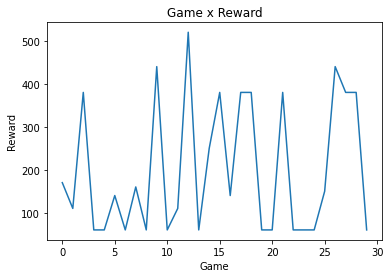

Mean reward: 200.33333 Std reward: 153.89354
win: 0 loss: 30


In [ ]:
log['rewards'], log['win'], log['loss']  = evaluate(model, det=True, num_episodes=30)
log['mean'] = np.mean(log['rewards'])
log['std'] = np.std(log['rewards'])

plt.plot(log['rewards'])
plt.ylabel('Reward')
plt.xlabel('Game')
plt.title('Game x Reward')
plt.show()

print("Mean reward:", log['mean'], "Std reward:", log['std'])
print("win:", log['win'], "loss:", log['loss'])


## Funções auxiliares para video


In [ ]:
# Set up fake display; otherwise rendering will fail
import os
os.system("Xvfb :1 -screen 0 1024x768x24 &")
os.environ['DISPLAY'] = ':1'

In [ ]:
import base64
from pathlib import Path

from IPython import display as ipythondisplay

def show_videos(video_path='', name=''):
  """
  Taken from https://github.com/eleurent/highway-env

  :param video_path: (str) Path to the folder containing videos
  :param prefix: (str) Filter the video, showing only the only starting with this prefix
  """
  html = []
  for mp4 in Path(video_path).glob("{}*.mp4".format(name)):
      video_b64 = base64.b64encode(mp4.read_bytes())
      html.append('''<video alt="{}" autoplay 
                    loop controls style="height: 400px;">
                    <source src="data:video/mp4;base64,{}" type="video/mp4" />
                </video>'''.format(mp4, video_b64.decode('ascii')))
  ipythondisplay.display(ipythondisplay.HTML(data="<br>".join(html)))

In [ ]:
from stable_baselines3.common.vec_env import VecVideoRecorder, DummyVecEnv

def record_video(env_id, model, video_length=1000, prefix='', video_folder= videodir):
  """
  :param env_id: (str)
  :param model: (RL model)
  :param video_length: (int)
  :param prefix: (str)
  :param video_folder: (str)
  """
  eval_env = DummyVecEnv([lambda: gym.make(enviroment)])
  # Start the video at step=0 and record X steps
  eval_env = VecVideoRecorder(eval_env, video_folder=video_folder,
                              record_video_trigger=lambda step: step == 0, video_length=video_length,
                              name_prefix=prefix)

  obs = eval_env.reset()
  for _ in range(video_length):
    action, _ = model.predict(obs, deterministic=True)
    obs, _, _, _ = eval_env.step(action)

  # Close the video recorder
  eval_env.close()

### Visualizando o agente treinado

In [ ]:
def save_log(log, agent, path):
  #path = os.path.abspath(os.getcwd())
  #path = os.path.join(path, 'results')
  print('Save log in %s ' % path)
  #timestr = time.strftime("%Y%m%d-%H%M%S")
  name_file = agent + '-' + timestr + '.pkl'
  name_file = os.path.join(path, name_file)
  if not os.path.exists(path):
      os.makedirs(path)
  a_file = open(name_file, "wb")
  pickle.dump(log, a_file)
  a_file.close()

  name_file = agent + '-' + timestr
  #salvando o video
  record_video(enviroment, model, video_length=1000, prefix=name_file, video_folder=videodir)
  print('video - Saving local')
  #mostrando o video salvo
  show_videos(videodir, name=name_file)


In [ ]:
save_log(log, agent, results_path)

Save log in DQN_20210121-200856/results_DQN_20210121-200856 
video - Saving local


## TensorBoard

In [ ]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
%tensorboard --logdir "$experiment_name"/logs_"$experiment_name"

In [ ]:
!cp -r "$experiment_name" /content/drive/MyDrive/T2_ReinforcementLearning/Results/

In [ ]:
#!tensorboard dev upload \
#  --logdir logs \
#  --name "(optional) My latest experiment" \
#  --description "(optional) Simple comparison of several hyperparameters" \
#  --one_shot